# Introduction to Unsupervised Learning

In this lab you will work with **unsupervised learning**. Unsupervised learning attempts to find inherent structure or relationships in complex data. Unsupervised learning does not use labeled cases in contrast with supervised learning. 

There are number of approaches to unsupervised learning. In this lab you will work with two widely used **clustering** methods, **K-means clustering** and **hierarchical**.

## K-means clustering

K-means clustering separates a dataset into K clusters of equal variance. The number of clusters, K, is user defined. The basic algorithm has the following steps:
1. A set of K centroids are randomly chosen. 
2. Clusters are formed by minimizing variance within each cluster. This metric is also know as the **within cluster sum of squares** (see further discussion in the section on evaluating clusters). This step partitions the data into clusters with minimum squared distance to the centroid of the cluster. 
3. The centroids are moved to mean of each cluster. The means of each cluster is computed and the centroid is moved to the mean. 
4. Steps 2 and 3 are repeated until a stopping criteria is met. Typically, the algorithm terminates when the within cluster variance decreases only minimally. 
5. The above steps are repeated starting with a random start of step 1. The best set of clusters by within cluster variance and between cluster separation are retained.  

Since K-means clustering relies only on basic linear algebra operations, the method is massively scalable. Out-of-core K-means clustering algorithms are widely used. However, this method assumes equal variance of the clusters, a fairly restrictive assumption. In practice, this criteria is almost never true, and yet K-means clustering still produces useful results. 

## Hierarchical clustering

Hierarchical clustering methods make fewer distributional assumptions when compared to K-means methods. However, K-means methods are generally more scalable, sometimes very much so. 

Hierarchical clustering creates clusters by either a **divisive** method or **agglomerative** method. The divisive method is a "top down" approach starting with the entire dataset and then finding partitions in a stepwise manner.  The later method is known as agglomerative clustering is a "bottom up** approach. In this lab you will work with agglomerative clustering which roughly works as follows:
1. The **linkage distances** between each of the data points is computed.
2. Points are clustered pairwise with their nearest neighbor. 
3. Linkage distances between the clusters are computed.
4. Clusters are combined pairwise into larger clusters.
5. Steps 3 and 4 are repeated until all data points are in a single cluster. 

The linkage function can be computed in a number of ways:
- **Ward** linkage measures the increase in variance for the clusters being linked,
- **Average** linkage uses the mean pairwise distance between the members of the two clusters, 
- **Complete** or **Maximal** linkage uses the maximum distance between the members of the two clusters.

Several different distance metrics are used to compute linkage functions including:
- **Euclidean** or **l2** distance is the most widely used. This metric is only choice for the Ward linkage method. 
- **Manhattan** or **l1** distance is robust to outliers and has other interesting properties. 

## A first example

With the above bit of theory in mind, you will now apply both K-means and agglomerative clustering modes to a set of synthetic data. 

First, execute the code in the cell below to load the packages required to run the rest of this notebook. 

In [35]:
library(ggplot2)
library(MASS)
library(gridExtra)
library(cluster)
library(repr)

options(repr.plot.width=4, repr.plot.height=4) # Set the initial plot area dimensions

The code in the  cell below creates synthetic data from bivariate Normal distribution with mean of $\{ 0,0 \}$ and a covariance matrix:

$$cov(X) =  \begin{bmatrix}
  1.0 & 0.4 \\
  0.4 & 1.0
 \end{bmatrix}$$
 
 Execute this code.

In [36]:
gen_data = function(n, mu, cov){
    sample = data.frame(mvrnorm(n = n, mu = mu, Sigma = cov))
    names(sample) = c('x','y')
    sample
    }

set.seed(124)
cov = matrix(c(1.0, 0.4, 0.4, 1.0), nrow =2, ncol = 2)
mean = c(0.0, 0.0)
sample = gen_data(100, mean, cov)

print(dim(sample))
head(sample)

[1] 100   2


x,y
-0.9017869,-1.41587953
0.6608505,-0.59672353
-1.2430814,-0.03371225
0.3360568,0.01919935
1.3445898,1.04079149
1.1025624,0.14319060


Execute the code in the cell below to create simulate data from two difference distributions. 

In [37]:
set.seed(1445)
cov = matrix(c(1.0, 0.8, 0.8, 1.0), nrow =2, ncol = 2)
mean = c(3.0, 0.0)
sample2 = gen_data(100, mean, cov)
print(dim(sample2))

set.seed(45)
cov = matrix(c(1.0, 0.8, 0.8, 1.0), nrow =2, ncol = 2)
mean = c(-3.0, 0.0)
sample3 = gen_data(100, mean, cov)
print(dim(sample3))

[1] 100   2
[1] 100   2


Execute the code in the cell below to display the data simulated from the three distributions.

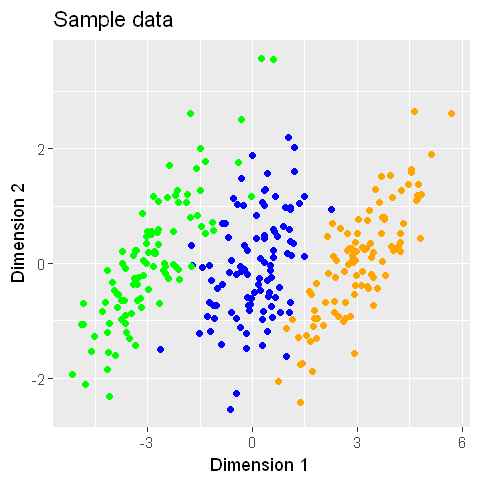

In [38]:
plot_dat = function(samp1, samp2, samp3){
    ggplot() + 
          geom_point(data = samp1, aes(x,y), color = 'blue') + 
          geom_point(data = samp2, aes(x,y), color = 'orange') + 
          geom_point(data = samp3, aes(x,y), color = 'green') + 
          xlab('Dimension 1 ') + ylab('Dimension 2') + 
          ggtitle('Sample data')
}

plot_dat(sample, sample2, sample3)

Notice that the three distributions are mostly separated, with some overlap.

Execute the code in the cell below to concatenate the data from the three numpy arrays. 

***
**Note:** The `rbind` function allocates memory for the new data frame on each binding operation. Using `rbind` repeatedly will result in inefficient R code. 
***

In [39]:
## Bind the three samples
sample = rbind(sample, sample2, sample3)

## ZScore scale the columns
for(col in c('x','y')){
    mean_col = mean(sample[,col])
    sd_col = sd(sample[,col])
    sample[,col] = (sample[,col] - mean_col)/sd_col
}

dim(sample)

[1] 300   2

Next, you will create a K-means clustering model by the following steps in the code below:
1. A K-means clustering model is defined with K = 3 (3 centers).
2. The assignments to the clusters are printed. 

Execute this code. 

In [40]:
set.seed(4455)
kmeans_3 = kmeans(sample[,c('x','y')], centers = 3)
sample[,'assignment'] = kmeans_3$cluster
sample$assignment

[1] 3 3 2 3 1 1 1 3 3 1 1 3 3 1 1 1 3 3 3 2 3 1 3 1 2 3 1 3 2 2 1 3 3 3 3 1 1
 [38] 3 2 2 3 1 1 1 3 3 3 3 3 1 3 3 3 3 3 3 3 3 2 3 3 1 2 3 1 3 3 1 1 1 3 2 3 1
 [75] 2 3 1 1 1 1 1 1 1 3 2 3 1 1 1 3 3 3 1 3 1 3 1 1 3 1 1 3 3 1 3 3 1 1 3 3 1
[112] 3 3 1 3 1 3 1 3 3 1 1 1 1 3 3 3 1 3 1 1 1 3 1 1 1 1 3 3 1 3 3 3 3 3 1 1 3
[149] 1 1 3 3 3 1 3 1 1 1 3 1 3 3 3 1 3 1 1 1 3 1 3 1 1 1 1 1 1 1 3 1 1 3 1 1 3
[186] 1 1 1 3 1 3 1 1 3 1 3 1 1 1 1 2 2 2 2 2 2 2 2 1 2 2 2 1 1 2 2 2 2 1 2 2 2
[223] 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2
[260] 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2
[297] 2 2 1 2

Execute the code in the cell below to plot the locations of the cluster assignments. 

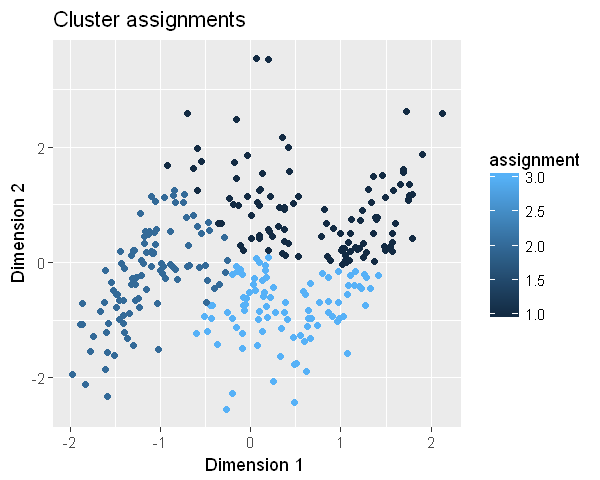

In [41]:
plot_clusters = function(df){
    options(repr.plot.width=5, repr.plot.height=4)
    ggplot(df, aes(x,y, color = assignment)) +
            geom_point() + 
          xlab('Dimension 1 ') + ylab('Dimension 2') + 
          ggtitle('Cluster assignments')
}

plot_clusters(sample)

Examine this plot. For the most part, the clusters follow the simulated data distributions. Notice that the central cluster approximately follows the outline of the central distribution. Additionally, the cluster boundaries appear to be linear. This behavior is likely a result of the overlap of these distributions. 

Now you will compare the result of the K-means clustering with agglomerative clustering. The code in the cell below performs the following processing:
1. Computes a pair-wise distance matrix, for the distances between the data points. Note that for a large dataset this process can be computationally and memory intensive. 
2. Computes the linkages with the `hclust` function. 
3. Creates cluster assignments with the `cutree` function. 

Execute this code. 

In [42]:
set.seed(7799)
dist_mat = dist(sample[,c('x','y')])
a_clusts = hclust(dist_mat)
agglomerative_3 = cutree(a_clusts, k = 3)
sample[,'assignment'] = agglomerative_3
sample$assignment

[1] 1 1 1 2 2 2 2 2 2 2 2 1 1 2 1 2 1 1 1 1 1 1 2 3 1 2 2 1 1 1 1 1 1 1 1 1 2
 [38] 1 1 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 3 1 1 2 1 1 3 2 1 1 1 1 1
 [75] 2 2 1 2 1 2 1 2 2 1 1 1 2 2 3 1 1 2 2 1 2 1 2 3 1 3 2 1 2 2 2 1 2 2 2 1 2
[112] 1 2 3 1 2 1 2 1 2 2 2 2 2 2 1 2 2 1 2 2 2 1 2 2 2 2 1 1 2 1 2 1 2 1 2 2 2
[149] 3 2 1 2 1 2 1 2 2 2 1 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 3 2 1 2 2 1 2 2 1
[186] 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 1 1 1 1 1 1 1 1 3 1 1 1 3 3 1 1 1 1 3 1 1 1
[223] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
[260] 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1
[297] 1 1 3 1

Execute the code in cell below to visualize the cluster assignments for the agglomerative models. 

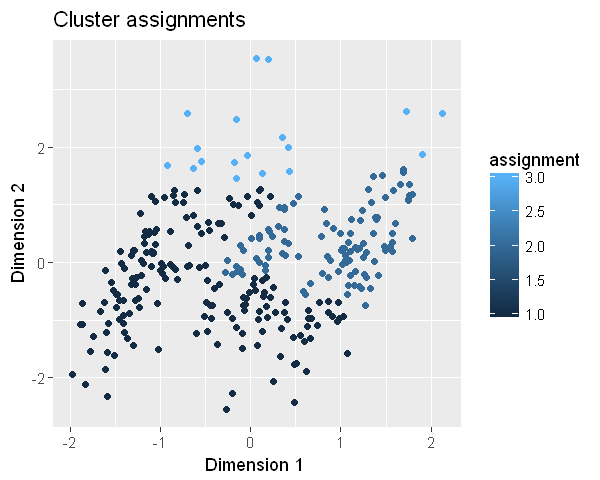

In [43]:
plot_clusters(sample)

These results are quite different from the k-means model. There is now a large main cluster and two smaller clusters on the periphery of the space.  

The plot method for the agglomerative clustering model will display the dendrogram for the model. 

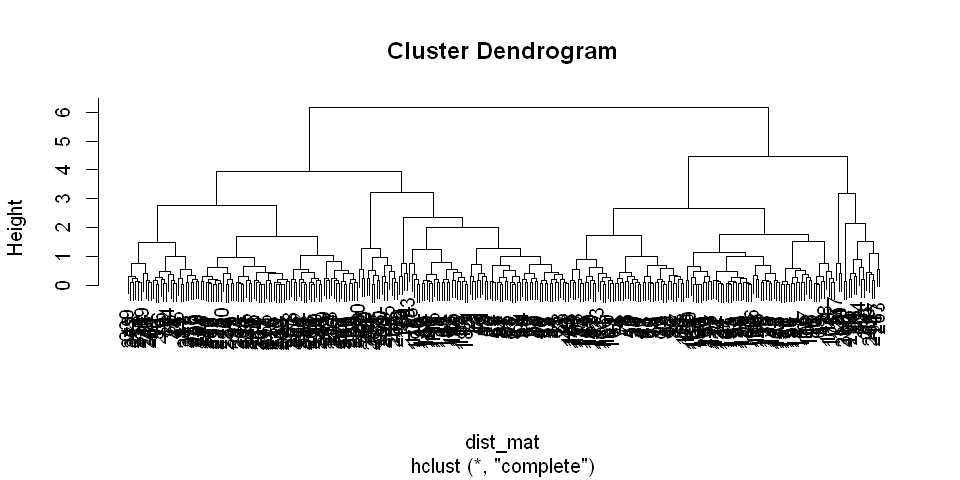

In [44]:
options(repr.plot.width=8, repr.plot.height=4)
plot(a_clusts)

The dendrogram represents the linkages between the data points. The `cutree` function cuts the dentrogram or tree as the specified number of branches (clusters). The vertical distance on the diagram indicates the separation between the clusters. You can see that the separation decreases as the number of clusters increases. The individual data points are on the tree at the bottom of the dendrogram. 

The foregoing 3 cluster models were applied to the three simulated distributions. What will be the result of using other numbers of clusters? 

Execute the code in the cell below to compute a K-means cluster model, with K=2, and display the assignments.

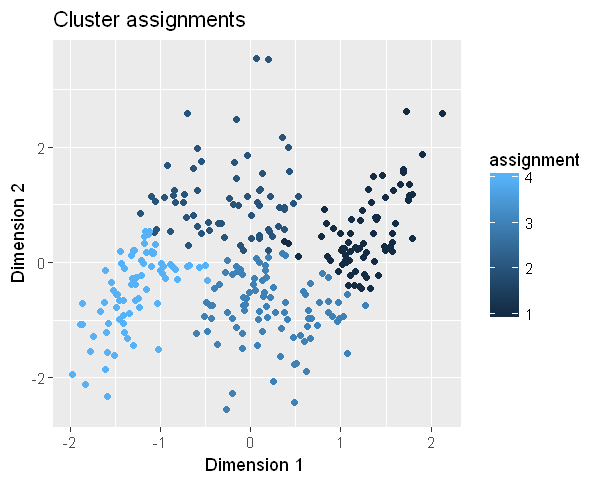

In [45]:
set.seed(4455)
kmeans_4 = kmeans(sample[,c('x','y')], centers = 4)
sample[,'assignment'] = kmeans_4$cluster
plot_clusters(sample)

To compare the K-means model with an agglomerative clustering model with two clusters, execute the code in the cell below. Notice that the distance matrix or linkages do not need to be recomputed. 

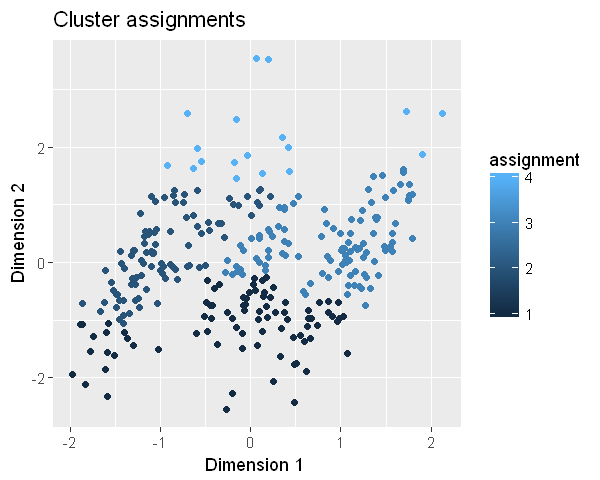

In [46]:
agglomerative_4 = cutree(a_clusts, k = 4)
sample[,'assignment'] = agglomerative_4
plot_clusters(sample)

Compare these results. The K=2 K-means model has roughly divided the data in half. The 2 cluster agglomerative model has created a large cluster of near points along with a smaller cluster of near points. 

Next, you will explore the differences between K-means and agglomerative clustering methods with 4 clusters. Execute the code in the cell below to compute the K=4 K-means model and display the assignments. 

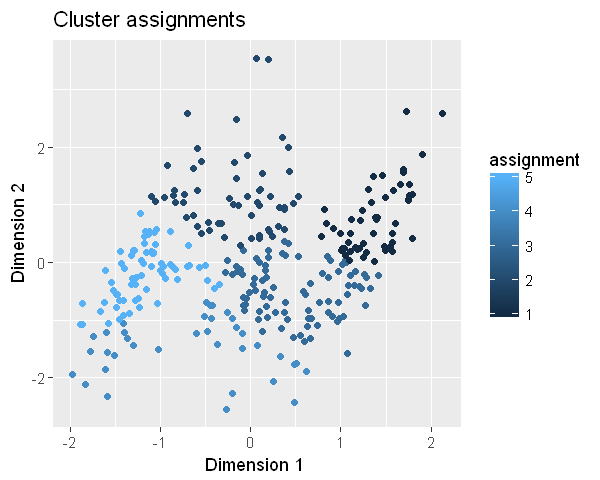

In [47]:
set.seed(4455)
kmeans_5 = kmeans(sample[,c('x','y')], centers = 5)
sample[,'assignment'] = kmeans_5$cluster
plot_clusters(sample)

Next, execute the code in the cell below to compute and display the assignments for an agglomerative clustering model with 4 clusters.

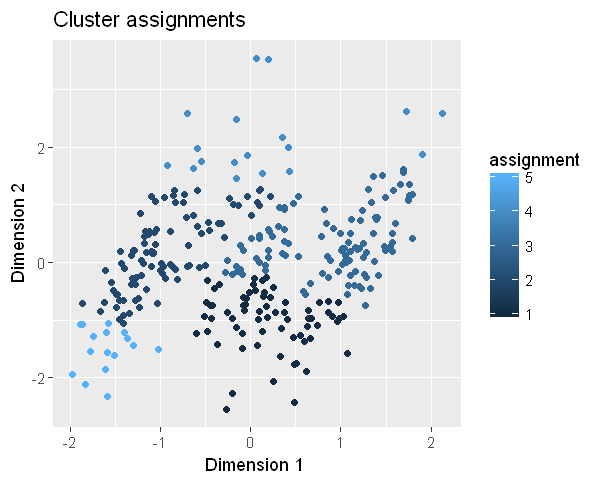

In [48]:
agglomerative_5 = cutree(a_clusts, k = 5)
sample[,'assignment'] = agglomerative_5
plot_clusters(sample)

Examine the differences between the assignments for the K-means and agglomerative clustering methods. Notice that the K-means method has created 4 clusters divided along the first dimension. Whereas, the agglomerative clustering has identified portions of the left and right distribution and divided the central distribution. At least for this case, the structure found by agglomerative clustering fits the situation better than the k=4 model. 

## Evaluating cluster models

Now that you have created some clustering models, you are likely wondering how can you evaluate these models and perform model selection. There are a number of metrics you can use to evaluate and compare clustering models. However, you should always keep in mind that the best model, should be selected based on the problem you are trying to solve.

One useful metric for clusters is the **within cluster sum of squares** or **WCSS**. Intuitively, clusters should have minimal dispersion and therefore minimal WCSS. The  

$$WCSS = Min \sum_i \sum_{j\ in\ cluster\ i} ||x_j - c_i||^2 \\
where\\
c_i = center\ of\ ith\ cluster\\ 
and\\
||x_j - c_i|| = distance\ between\ data\ x_j\ and\ center\ c_i
$$

We can use WCSS to compare different cluster models. Models with smaller SSW have tighter clusters and, therefore smaller WCSS. 

****
**Note:** WCSS is also referred to as **inertia**. 
****

The **between cluster sum of squares** or **BCSS** is a related metric. Whereas WCSS measures how tight the clusters are BCSS is a measure of the separation between the clusters. To compute the BCSS, observe that the **total sum of squares** or **TSS** must equal the sum of the WCSS and BCSS:

$$
TSS = BCSS + WCSS\\
where\\
TSS = \sum_i (x_i - \mu)^2\\
where\\
\mu = mean\ of\ all\ data\ samples
$$

Notice that the TSS is just the variance of all data points. The BCSS is then just the difference between TSS and WCSS.

The **silhouette coefficient** or **SC** is another clustering metric. The silhouette coefficient measures the ratio between the distances within a cluster and distances to the nearest adjacent cluster. The SC for the $ith$ member of a cluster is computed as follows:

$$
SC_i = \frac{b_i -a_i }{max(a_i, b_i)}\\
where\\
a_i = average\ distance\ from\ point\ i\ to\ other\ members\ of\ the\ same\ cluster\\
b_i = average\ distance\ from\ point\ i\ to\ members\ of\ an\ adjacent\ cluster
$$

The SC has some important properties First, the SC values are limited as a result of the normalization:

$$\{ -1 \le SC \le 1 \}$$

For the case where the clusters are compact and well separated from adjacent clusters the following relationship holds:

$$if\ a_i \lt b_i\ then\ SC \gt 0$$

However,  for dispersed clusters that are not well separated from adjacent clusters the following relationship holds:

$$if\ a_i \gt b_i\ then\ SC \lt 0$$

In other words, the tighter the cluster and the further it is from members of the adjacent cluster. The closer the SC values will be to 1. However, if the cluster is dispersed and the distances to the adjacent cluster is small, the SC will have a value less than 0. 

In summary, you want to find a model with SC values close to 1. If the SC is consistently less than zero the clustering model is probably not that useful. 

****
**Note:** The WCSS and BCSS metrics have the concept of the clustering having multivariate-Normal distributions. Therefore, these metrics are strictly only applicable to K-means cluster. This fact means that WCSS and BCSS are not useful metrics for agglomerative clustering. The SC can be computed using various metrics so is more generally applicable to most clustering methods. 
****

In the previous section, you compared cluster models using visualization of the cluster assignments. The code in the cell below computes and displays WCSS, BCSS and the approximate average SC for the three K-means clustering models tried. Execute this code and examine the result.  

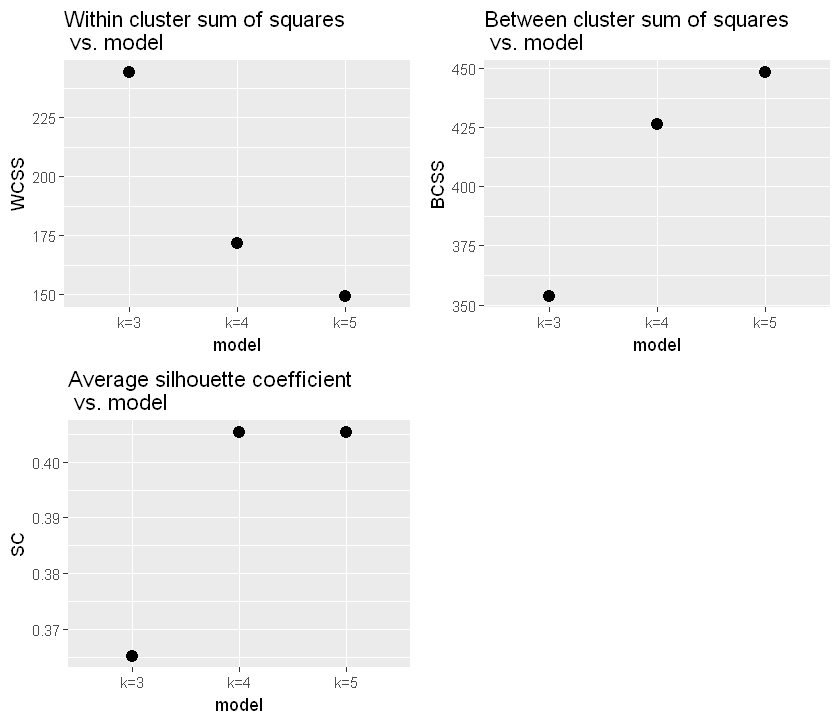

In [49]:
plot_clust_metrics = function(kmeans_2, kmeans_3, kmeans_4){
    options(repr.plot.width=7, repr.plot.height=6) # Set the plot area dimensions
    
    ## Create a data frame with the sum of the WCSS and BCSS and approximate ave SC as columns
    kmeans_metrics = data.frame(model = c('k=3', 'k=4', 'k=5'), 
                            WCSS = c(sum(kmeans_3$withinss), sum(kmeans_4$withinss), sum(kmeans_5$withinss)),
                            BCSS = c(sum(kmeans_3$betweenss), sum(kmeans_4$betweenss), sum(kmeans_5$betweenss)),
                            SC = c(mean(silhouette(kmeans_3$cluster, dist_mat)[,3]),
                                   mean(silhouette(kmeans_4$cluster, dist_mat)[,3]),
                                   mean(silhouette(kmeans_4$cluster, dist_mat)[,3])))
    ## Create side by side plots of WCSS and BCSS vs. the model
    p_wcss = ggplot(kmeans_metrics, aes(model, WCSS)) + geom_point(size = 3) +
                ggtitle('Within cluster sum of squares \n vs. model')
    p_bcss = ggplot(kmeans_metrics, aes(model, BCSS)) + geom_point(size = 3) +
                ggtitle('Between cluster sum of squares \n vs. model')
    p_sc = ggplot(kmeans_metrics, aes(model, SC)) + geom_point(size = 3) +
                ggtitle('Average silhouette coefficient \n vs. model')
    grid.arrange(p_wcss, p_bcss, p_sc, ncol = 2)
    }

plot_clust_metrics(kmeans_2, kmeans_3, kmeans_4)

Examine these results and notice the following:
1. The WCSS deceases with the number of clusters, whereas the BCSS increases with the number of clusters. This behavior is expected. Using more clusters results in smaller clusters with lower WCSS. However, the separation between the clusters decrease with larger number of clusters leading to increased BCSS. 
2. The WCSS decreases significantly between 2 and 3 clusters, but is only marginally lower for 4 clusters than 3. The BCSS increases more between 2 and 3 clusters than between 3 and 4 clusters. 
3. The average SC is greatest for K=3, however the values are lower for K=2 and K=4 respectively. 

Taken together, these metrics indicate there is not a great difference between the 3 and 4 cluster models. However, the 2 cluster  model is clearly inferior. The K=3 model appears to be best overall. 

Now, execute the code in the cell below to compute and display the SC for the three agglomerative clustering models. 

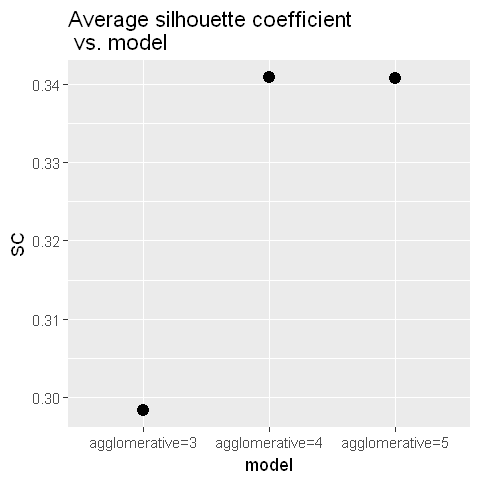

In [50]:
options(repr.plot.width=4, repr.plot.height=4) # Set the plot area dimensions

SC_metrics = data.frame(model = c('agglomerative=3', 'agglomerative=4', 'agglomerative=5'),
                        SC = c(mean(silhouette(agglomerative_3, dist_mat)[,3]),
                                mean(silhouette(agglomerative_4, dist_mat)[,3]),
                                mean(silhouette(agglomerative_5, dist_mat)[,3])))

ggplot(SC_metrics, aes(model, SC)) + geom_point(size = 3) +
                ggtitle('Average silhouette coefficient \n vs. model')

The 4 and 5 cluster agglomerative models are nearly indistinguishable. 

## Another example

The foregoing examples provide a basic introduction to K-means and agglomerative clustering. In this section you will work with another set of synthetic data and explore how changes in distance metric and linkage function change agglomerative clustering results. 

The code in the cell below computes another synthetic dataset comprised of three distributions. One of these distributions has a much larger covariance than in the previous example. This fact will stress the equal variance assumption of the K-means clustering model. 

Execute this code to generate and display the dataset. 

[1] 100   2
[1] 100   2


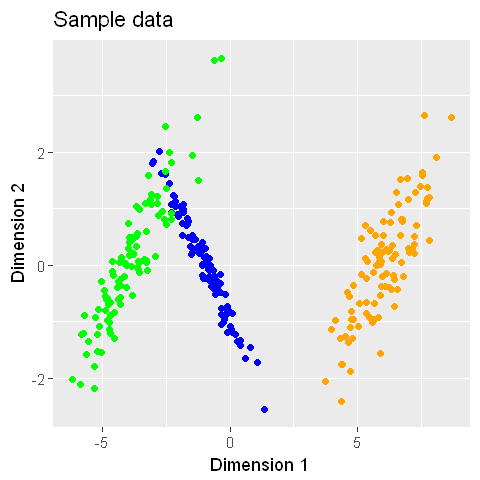

In [51]:
options(repr.plot.width=4, repr.plot.height=4) # Set the plot area dimensions

set.seed(124)
cov = matrix(c(1.0, -0.98, -0.98, 1.0), nrow =2, ncol = 2)
mean = c(-1.0, 0.0)
sample1 = gen_data(100, mean, cov)

set.seed(1445)
cov = matrix(c(1.0, 0.8, 0.8, 1.0), nrow =2, ncol = 2)
mean = c(6.0, 0.0)
sample2 = gen_data(100, mean, cov)
print(dim(sample2))

set.seed(45)
cov = matrix(c(1.0, 0.9, 0.9, 1.0), nrow =2, ncol = 2)
mean = c(-4.0, 0.0)
sample3 = gen_data(100, mean, cov)
print(dim(sample3))

plot_dat(sample1, sample2, sample3)

As expected the dataset is comprised of three distinct distributions. The distribution in the center exhibits high covariance. 

Now, execute the code in the cell below to concatenate the three distributions into a single data frame and Z-Score normalize the feature columns. 

In [52]:
## Bind the three samples
sample_2 = rbind(sample1, sample2, sample3)

## ZScore scale the columns
for(col in c('x','y')){
    mean_col = mean(sample_2[,col])
    sd_col = sd(sample_2[,col])
    sample_2[,col] = (sample_2[,col] - mean_col)/sd_col
}

dim(sample_2)

[1] 300   2

A K=3 K-means model is a useful basis for comparison. Execute the code in the cell below to compute the model and display the cluster assignments.

[1] "SC =  0.436756424584305"


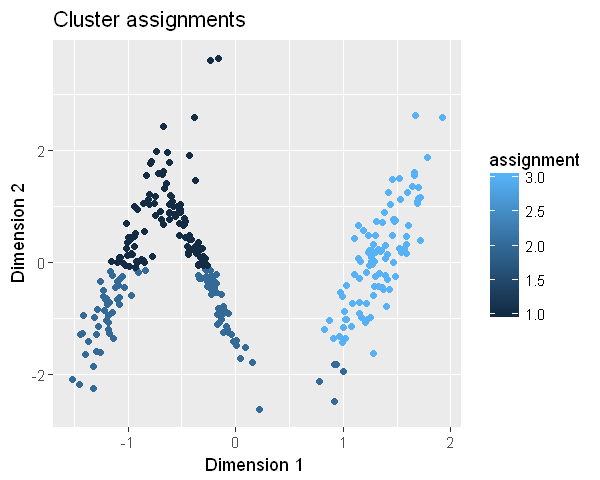

In [53]:
set.seed(4455)
dist_mat = dist(sample_2[,c('x','y')])
kmeans_3 = kmeans(sample_2[,c('x','y')], centers = 3)
sample_2[,'assignment'] = kmeans_3$cluster
print(paste('SC = ', as.character(mean(silhouette(kmeans_3$cluster, dist_mat)[,3]))))
plot_clusters(sample_2)

The k=3 K-means cluster model has largely separated the data on the right and split the data distributions on the left. 

Now, compute an 3-cluster agglomerative model using Ward linkage and Euclidean distance norms by executing the code in the cell below. 

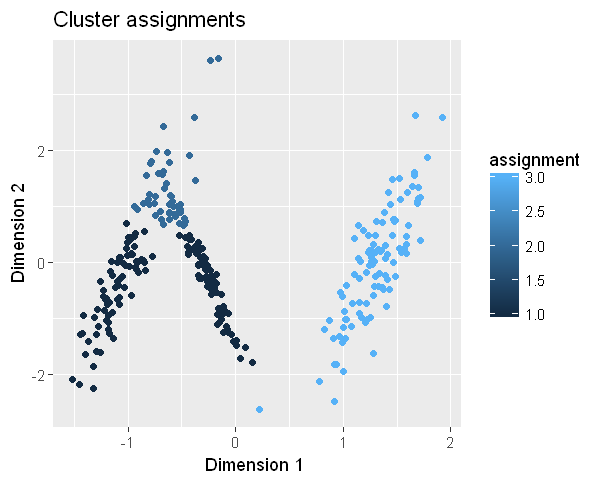

In [54]:
set.seed(5566)
dist_euc = dist(sample_2[,c('x','y')], method = "euclidean")
a_clusts_w = hclust(dist_euc, method = "ward.D")
agglomerative3_w = cutree(a_clusts_w, k = 3)
sample_2[,'assignment'] = agglomerative3_w
plot_clusters(sample_2)

The above results are only marginally different from those obtained for the k-means clustering algorithm. 

But, what will be the effect of using other linkage functions? To find out, execute the code in the cell below to compute and display the assignments of a 3-cluster agglomerative model using average linkage.

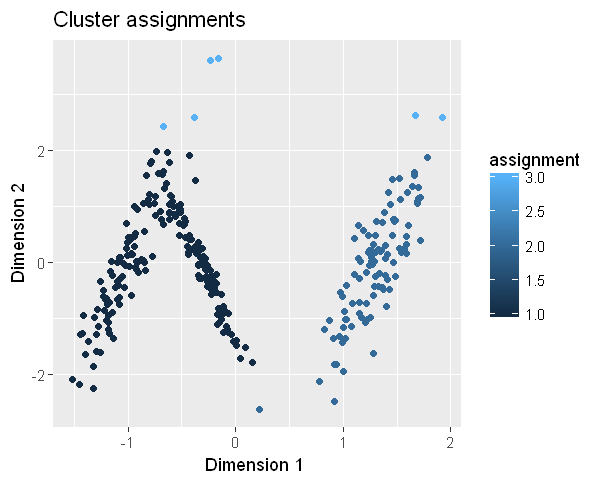

In [55]:
set.seed(4747)
a_clusts_a = hclust(dist_euc, method = "average")
agglomerative3_a = cutree(a_clusts_a, k = 3)
sample_2[,'assignment'] = agglomerative3_a
plot_clusters(sample_2)

The cluster assignments Follow the structure of the data rather well. Some outlining points in the upper part of the diagram are in a small cluster.

Now, execute the code in the cell below to compute and display the cluster assignments for a 3-cluster agglomerative model using complete or maximal linkage. 

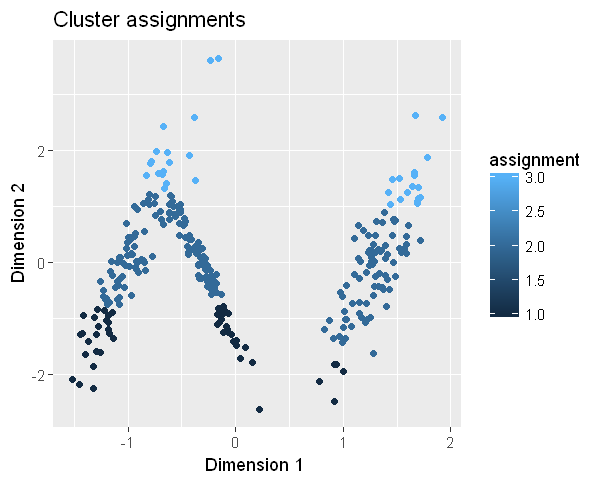

In [56]:
set.seed(5566)
a_clusts_c = hclust(dist_euc, method = "complete")
agglomerative3_c = cutree(a_clusts_c, k = 3)
sample_2[,'assignment'] = agglomerative3_c
plot_clusters(sample_2)

These cluster assignments are quite different from those seen before. However, the assignments seem a bit discordant with the data. 

Having tried several linkage functions, you will now explore using different distance metrics. The code in the cell below computes a 3-cluster agglomerative model with average linkage using the Manhattan or l1 distance metric. Execute this code and examine the class assignments displayed.

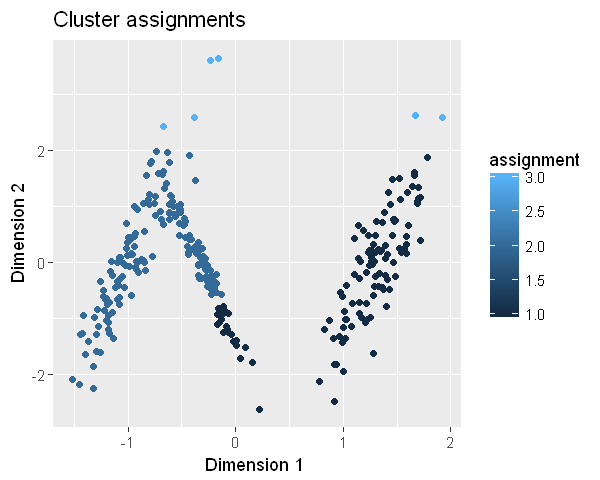

In [57]:
set.seed(5566)
dist_man = dist(sample_2[,c('x','y')], method = "manhattan")
a_clusts3_a_m = hclust(dist_man, method = "average")
agglomerative3_a_m = cutree(a_clusts3_a_m, k = 3)
sample_2[,'assignment'] = agglomerative3_a_m
plot_clusters(sample_2)

The class assignments displayed above are similar to the average linkage model using Euclidean distance. These results seem a bit less discordant with the structure of the data.

The final example computes and displays the assignments for a 3-cluster agglomerative model using complete or Ward linkage and the Manhattan distance.

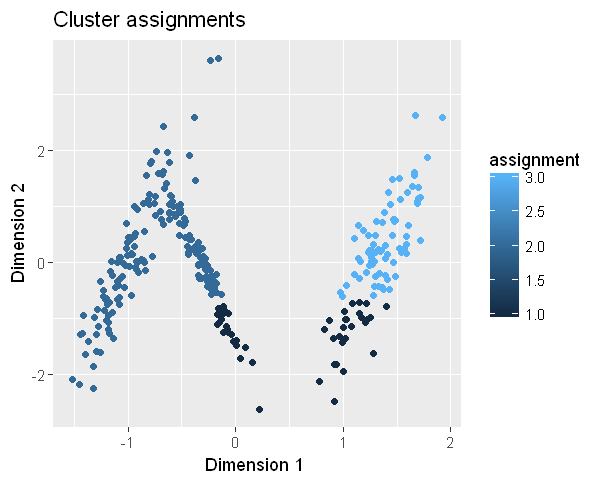

In [58]:
set.seed(66)
a_clusts3_w_m = hclust(dist_man, method = "ward.D")
agglomerative3_w_m = cutree(a_clusts3_w_m, k = 3)
sample_2[,'assignment'] = agglomerative3_w_m
plot_clusters(sample_2)

The choice of the Ward linkage has produced a different set of cluster assignments. These assignments seem to follow the structure of the data in an interesting way. 

Finally, compute the SCs for each of these models and compare them by executing the code in the cell below.

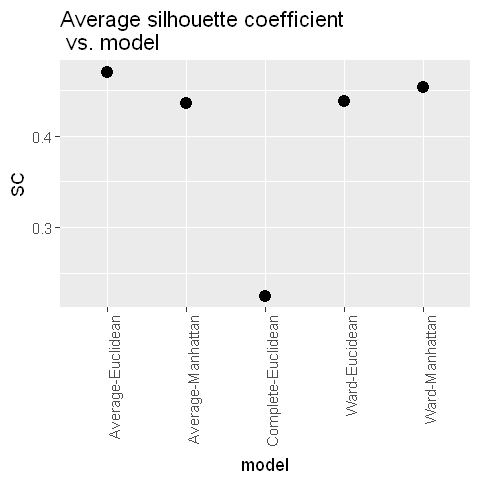

In [66]:
options(repr.plot.width=4, repr.plot.height=4) # Set the plot area dimensions

SC_metrics = data.frame(model = c('Ward-Eucidean', 'Average-Euclidean', 'Complete-Euclidean',
                                 'Average-Manhattan', 'Ward-Manhattan'),
                        SC = c(mean(silhouette(agglomerative3_w, dist_euc)[,3]),
                                mean(silhouette(agglomerative3_a, dist_euc)[,3]),
                                mean(silhouette(agglomerative3_c, dist_euc)[,3]),
                                mean(silhouette(agglomerative3_a_m, dist_man)[,3]),
                                mean(silhouette(agglomerative3_w_m, dist_man)[,3])))

ggplot(SC_metrics, aes(model, SC)) + geom_point(size = 3) +
                ggtitle('Average silhouette coefficient \n vs. model') +
                theme(axis.text.x = element_text(angle = 90, hjust = 1))

The model model using average linkage and Euclidean distance is the best by a small margin. Other models are nearly as good, except of the model using complete linkage and Euclidean distance. It is clear from the foregoing, that the choice of distance metric and linkage can have significant effect on the results of agglomerative clustering.  

## Summary

In this lab you have worked with two commonly used clustering models, K-means clustering and hierarchical agglomerative clustering. These methods are examples of unsupervised learning since they attempt to find interesting structure in data without using labels or marked cases.

For agglomerative cluster models the linkage can be any of:
- **Ward** or increase in variance,
- **Average** linkage or mean pairwise distance between the members of pairs of clusters, 
- **Complete** or **Maximal** linkage or maximum distance between the members of the two clusters.

Several different distance metrics are used to compute linkage functions:
- **Euclidian** or **l2**, 
- **Manhattan** or **l1**.

A critical problem for clustering models is to determine the number of clusters. Since there are no labels, model selection must be performed by a combination of visualization and metrics. Metrics used for evaluating cluster models include:
- The **within cluster sum of squares (WCSS)** and **between cluster sum of squares (BCSS)** are used for K-means clustering only. Ideally a good K-menas cluster model should have small WCSS and large BCSS. 
- Most any clustering model can be evaluated using **silhouette coefficient (SC)**. The SC measures the ratio between the distances within a cluster and distances to the nearest adjacent cluster.